In [1]:
import nltk
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk.data
import chardet
import re
import os
import json
from pathlib import Path
import spacy
import pandas as pd
import nltk.data

In [2]:
from collections import Counter
import spacy
from tabulate import tabulate
nlp = spacy.load('en_core_web_lg')
import nltk
from nltk.tokenize import sent_tokenize

In [3]:
# main function for generating pre-treated data 
def main():
    dir = "/Users/janine/Documents/NLP/Project/code/text_data/"
    raw_text_data = read_file(dir)
    valid_data = pre_processing(raw_text_data)
    return valid_data

In [4]:
# read file # same as siyang's code
def read_file(dir):
    json_file = Path('{}Raw-Harry-Potter-Series.json'.format(dir))
    book = {}
    if not json_file.exists():
        files = []
        pattern = '\.txt'
        for readfile in os.listdir(dir):
            if re.search(pattern, readfile):
                files.append(readfile)
        pattern = '(.+)\..+$'
        for file_name in files:
            decode_text = []
            with open(dir + file_name, 'rb') as f_read:
                text = f_read.readlines()
                for line in text:
                    type = chardet.detect(line)
                    line = line.decode(type["encoding"])
                    decode_text.append(line)
                file_name = re.findall(pattern, file_name)[0]
                book[file_name] = decode_text
            f_read.close()

        ##TODO:Save book to json file
        with open(dir + 'Raw-Harry-Potter-Series.json', 'a') as outfile:
            json.dump(book, outfile, ensure_ascii=False)
            outfile.write('\n')
    else:
        readfile = open('{}Raw-Harry-Potter-Series.json'.format(dir),"r")
        book = eval(readfile.read())
    return book

In [5]:
# data processing: we need each novel to be tokenized into sentences, not a whole novel, not tokens.
def pre_processing(data):
    
    data_into_sentences = {}
    
    for key in data.keys():
        text_of_book = data[key]
       
        pattern = r'^[¡]*'
        
        all_paragraph = []
        for para in text_of_book:
            para = para.strip('\n')
            para = re.sub(pattern, '', para)
            all_paragraph.append(para)
        
        all_sentence = []
        for i in all_paragraph:
            for j in sent_tokenize(i):
                all_sentence.append(j)

        data_into_sentences[key] = all_sentence


    return data_into_sentences

In [6]:
# Run main function and generate valid data
valid_data = main()

In [7]:
# See what valid_data looks like and check whether there is problem
print(valid_data.keys())

dict_keys(['Harry Potter and The Chamber Of Secrets', 'Harry Potter and the Deathly Hallows', 'Harry Potter and the Goblet of Fire', 'Harry Potter and The Half-Blood Prince', 'Harry Potter and the Order of the Phoenix', 'Harry Potter and the Prisoner of Azkaban', 'Harry Potter and the Sorcerer Stone'])


In [8]:
print(valid_data['Harry Potter and the Sorcerer Stone'][0])

CHAPTER ONE


In [9]:
print(valid_data['Harry Potter and the Sorcerer Stone'][1])

THE BOY WHO LIVED


In [10]:
print(valid_data['Harry Potter and the Sorcerer Stone'][2])

Mr. and Mrs. Dursley, of number four, Privet Drive, were proud to say that they were perfectly normal, thank you very much.


In [11]:
print(valid_data['Harry Potter and the Sorcerer Stone'][3])

They were the last people you'd expect to be involved in anything strange or mysterious, because they just didn't hold with such nonsense.


In [13]:
# Make the valid_data into content_json format as required # almost same as Janine's code
content_json = []
location = 0
#book1
for sentence in valid_data['Harry Potter and the Sorcerer Stone']:
    location = location + 1
    chunk = {"book_id":1}
    chunk["text"] = sentence
    chunk["location"] = location
    content_json.append(chunk)
#book2
for sentence in valid_data['Harry Potter and The Chamber Of Secrets']:
    location = location + 1
    chunk = {"book_id":2}
    chunk["text"] = sentence
    chunk["location"] = location
    content_json.append(chunk)
#book3
for sentence in valid_data['Harry Potter and the Prisoner of Azkaban']:
    location = location + 1
    chunk = {"book_id":3}
    chunk["text"] = sentence
    chunk["location"] = location
    content_json.append(chunk)
#book4
for sentence in valid_data['Harry Potter and the Goblet of Fire']:
    location = location + 1
    chunk = {"book_id":4}
    chunk["text"] = sentence
    chunk["location"] = location
    content_json.append(chunk)
#book5
for sentence in valid_data['Harry Potter and the Order of the Phoenix']:
    location = location + 1
    chunk = {"book_id":5}
    chunk["text"] = sentence
    chunk["location"] = location
    content_json.append(chunk)
#book6
for sentence in valid_data['Harry Potter and The Half-Blood Prince']:
    location = location + 1
    chunk = {"book_id":6}
    chunk["text"] = sentence
    chunk["location"] = location
    content_json.append(chunk)
#book7
for sentence in valid_data['Harry Potter and the Deathly Hallows']:
    location = location + 1
    chunk = {"book_id":7}
    chunk["text"] = sentence
    chunk["location"] = location
    content_json.append(chunk)

In [14]:
# See what the content_json looks like
print(type(content_json))
print('---')
print(content_json[:2])

<class 'list'>
---
[{'book_id': 1, 'text': 'CHAPTER ONE', 'location': 1}, {'book_id': 1, 'text': 'THE BOY WHO LIVED', 'location': 2}]


In [15]:
book_locations = (pd.DataFrame(content_json)
                  .reset_index()
                  .groupby('book_id')['index']
                  .min()
                  .to_dict()
                 )
book_locations

{1: 0, 2: 6765, 3: 14597, 4: 23969, 5: 42274, 6: 66082, 7: 80473}

In [16]:
len(content_json)

106706

In [17]:
# Create final_data for next step, namely find subject, verb, and object
final_data = []
for i in range(len(content_json)):
    final_data.append(content_json[i]["text"])

In [18]:
# See what the final_data looks like
print(final_data[50])

He'd forgotten all about the people in cloaks until he passed a group of them next to the baker's.


In [19]:
#extract all the name entities shown as the subject in the sentence

sub_verb_obj = []

def token_is_subject_with_action(token):
    nsubj = token.dep_ == 'nsubj'
    head_verb = token.head.pos_ == 'VERB'
    person = token.ent_type_ == 'PERSON'
    return nsubj and head_verb and person




for i in range(len(final_data)):
    doc = nlp(final_data[i])
    helper_nsubj = 0 
    
    for token in doc:
        if token_is_subject_with_action(token):
            helper_nsubj += 1
            token_nsubj = token


    
    if helper_nsubj==1:    
        span = doc[token_nsubj.head.left_edge.i:token_nsubj.head.right_edge.i+1]
        data = dict(
                    name = token_nsubj.orth_,
                    span = span.text,
                    verb = token_nsubj.head.lower_,
                    location = i
                    )

        sub_verb_obj.append(data)
            

print(len(sub_verb_obj)) 



26092


In [27]:
sub_berv_obj= pd.DataFrame(sub_verb_obj)
sub_berv_obj.to_csv('sub_verb.csv')

In [28]:
# See what the result looks like
print(sub_verb_obj[0])

{'name': 'Dursley', 'span': 'Mr. Dursley was the director of a firm called Grunnings, which made drills.', 'verb': 'was', 'location': 4}


In [29]:
print(sub_verb_obj[15])

{'name': 'Dursley', 'span': 'Mr. Dursley stopped dead.', 'verb': 'stopped', 'location': 56}


In [30]:
print(sub_verb_obj[1])

{'name': 'Dursley', 'span': 'Mrs. Dursley was thin and blonde and had nearly twice the usual amount of neck, which came in very useful as she spent so much of her time craning over garden fences, spying on the neighbors.', 'verb': 'was', 'location': 6}


In [31]:


action_df = pd.DataFrame(sub_verb_obj)

print('Unique Names:', action_df['name'].nunique())

most_common = (action_df
    .groupby(['name', 'verb'])
    .size()
    .groupby(level=0, group_keys=False)
    .nlargest(1)
    .rename('Count')
    .reset_index(level=1)
    .rename(columns={
        'verb': 'Most Common'
    })
)




Unique Names: 527


In [32]:
most_common.sort_values('Count', ascending=False).head(10)

,Most Common,Count
name,,
Harry,said,2525
Ron,said,1386
Hermione,said,1113
Dumbledore,said,618
Hagrid,said,347
Weasley,said,329
Lupin,said,221
Fred,said,215
Snape,said,207


showing order before name combination
 


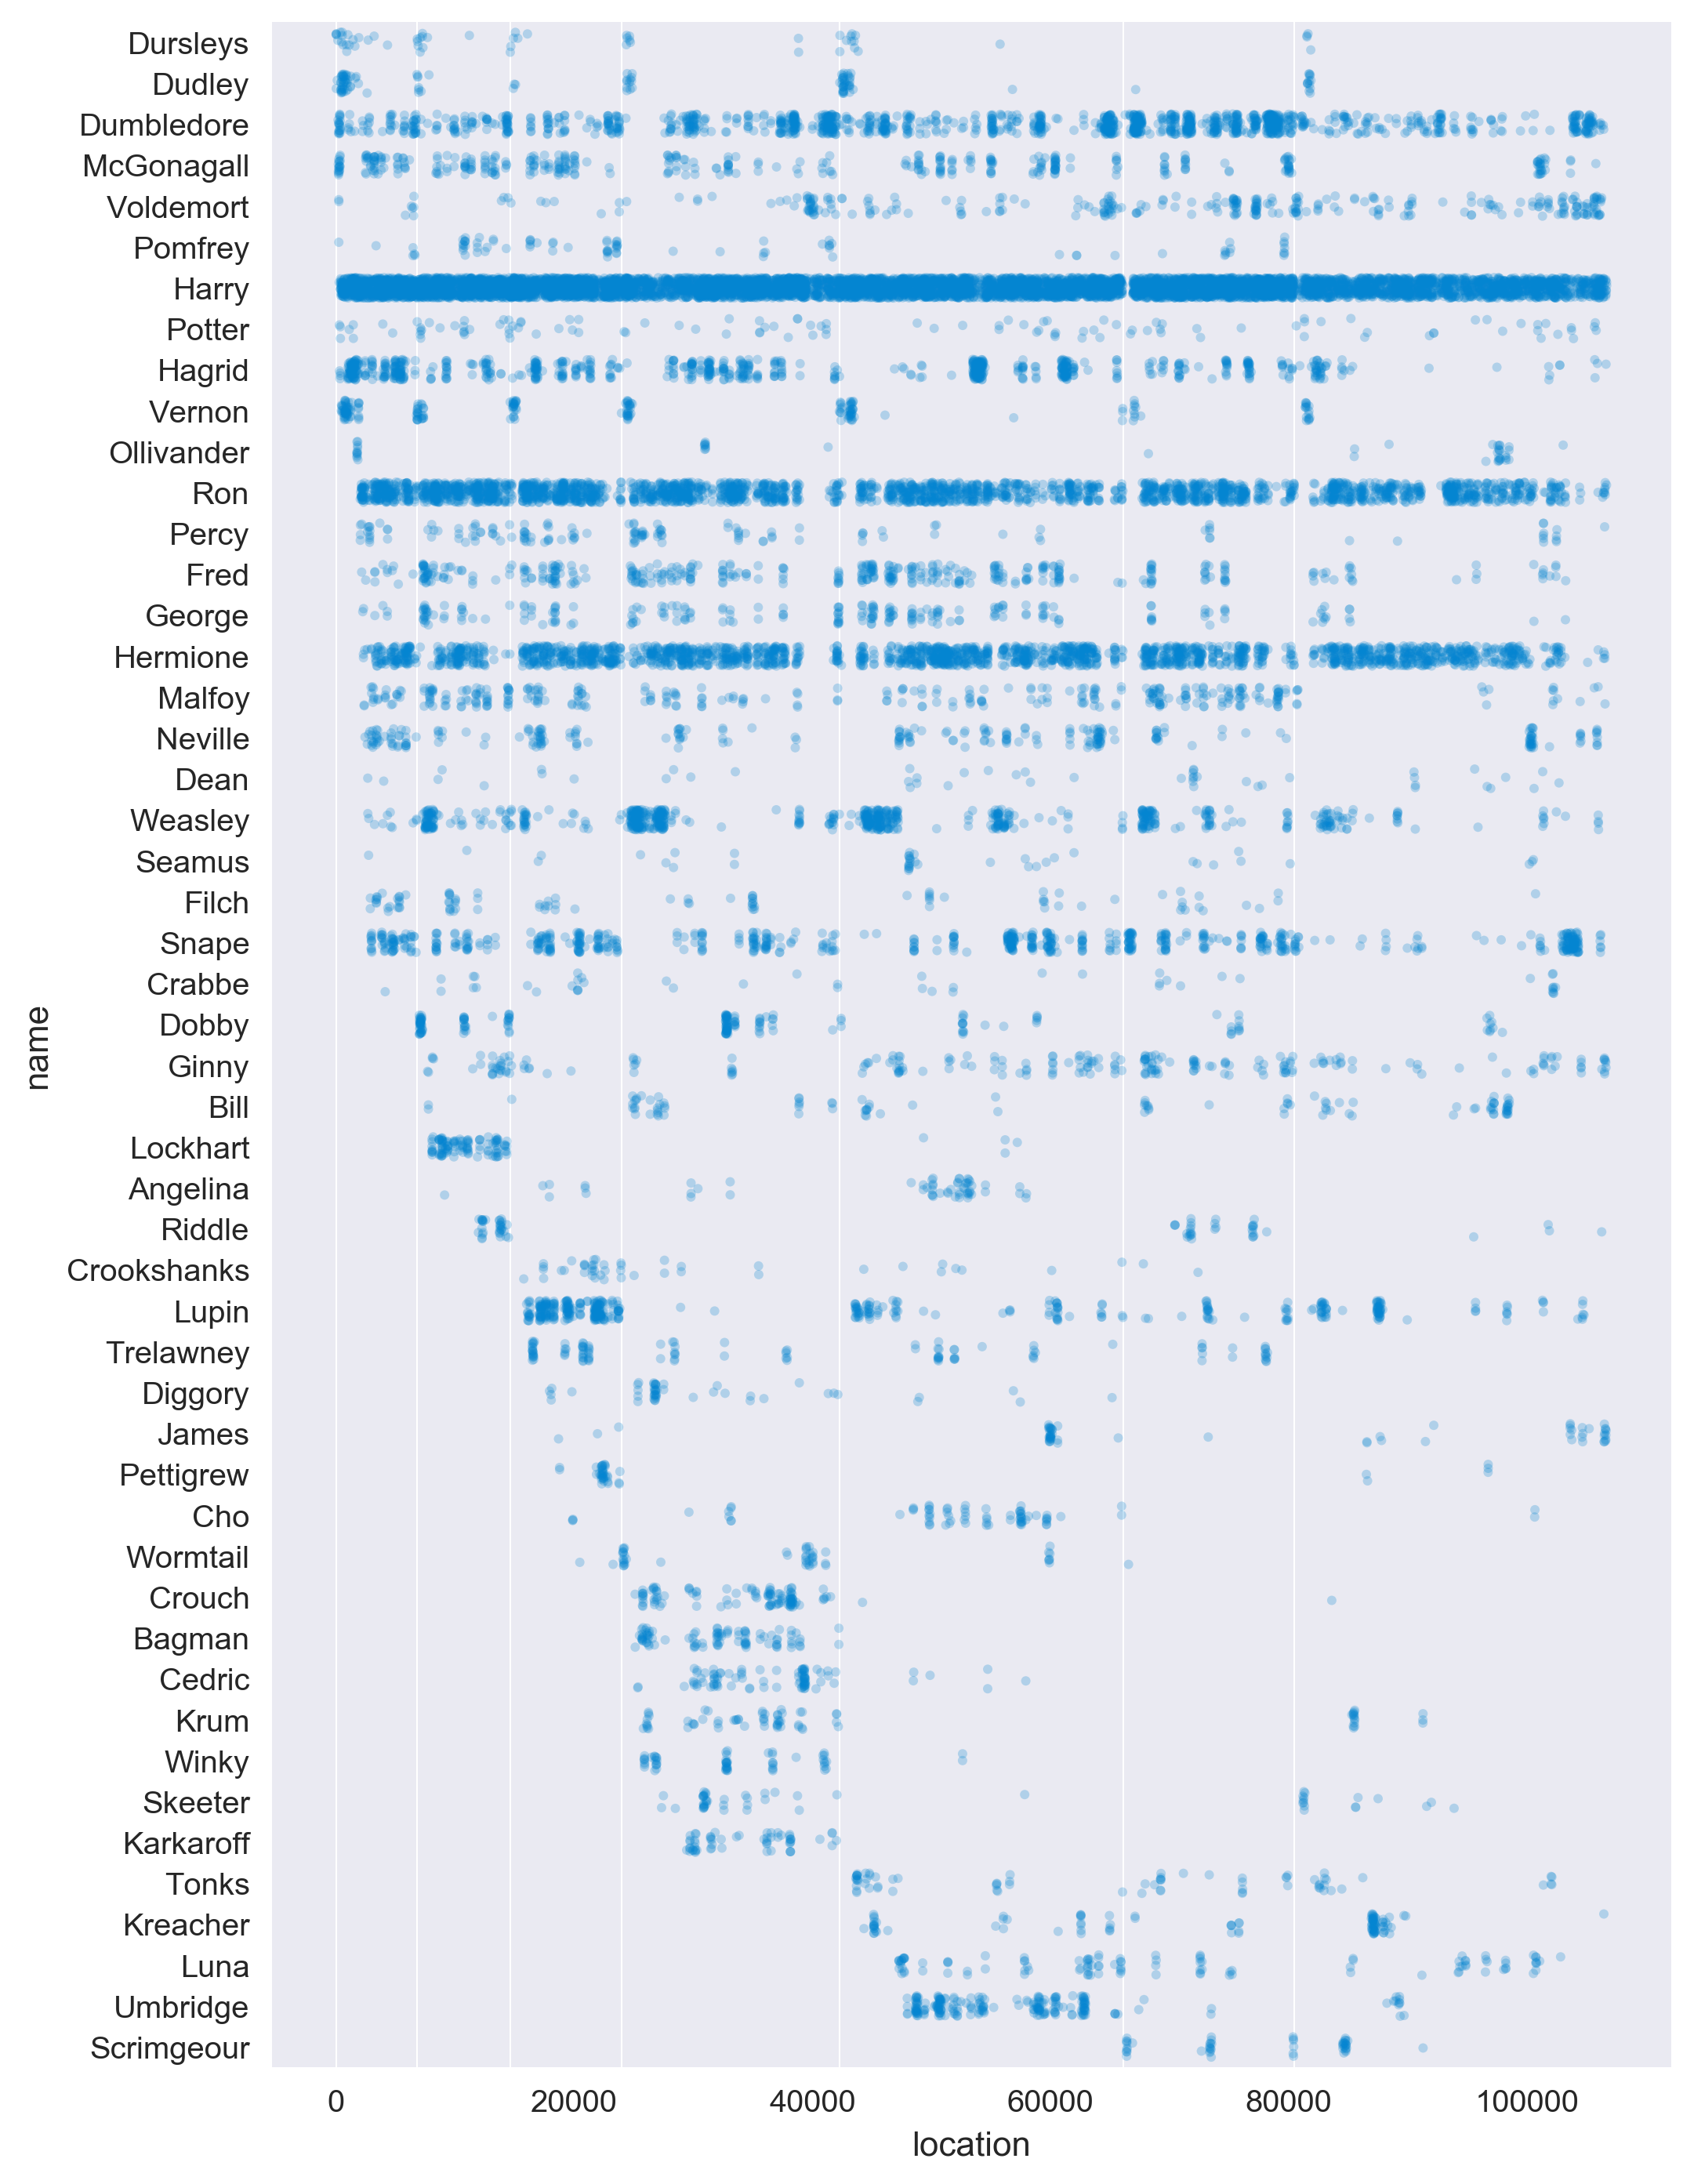

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(context='notebook', style='dark')
most_frequent_actors = list(action_df['name'].value_counts().index[:50])
top_actors_df = action_df[action_df['name'].isin(most_frequent_actors)].copy()
book_locations = (pd.DataFrame(content_json)
                  .reset_index()
                  .groupby('book_id')['index']
                  .min()
                  .to_dict()
                 )
fig, ax = plt.subplots(figsize=(8,12), dpi=144*2)
sns.stripplot(x='location', y='name', 
              data=top_actors_df, ax=ax,
              color='xkcd:cerulean',
              size=3, alpha=0.25, jitter=0.25)
sns.despine(bottom=True, left=True)

for book, verse_num in book_locations.items():
    ax.axvline(verse_num, alpha=1, lw=0.5, color='w')

print("showing order before name combination")
print(" ")